In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Contents

* [Executive Summary](#Executive-Summary)
* [fc1000 Feature Engineering](fc1000-Feature-Engineering)
* [Base Model](#Base-Model)
* [PCA Based Model](#PCA-Based-Model)
* [High Frequency Classes](#High-Frequency-Classes)
* [High Frequency With PCA](#High-Frequency-with-PCA)
* [Analyze Iterations at High Frequency and PCA](#Analyze-Iterations-at-High-Frequency-and-PCA)
* [Analyze Iterations at High Frequency without PCA](#Analyze-Iterations-at-High-Frequency-without-PCA)
* [Classification Report (With 2012)](#Classification-Report-(With-2012)
* [Classification Report (Without 2012)](#Classification-Report-(Without-2012)

# Executive Summary

The previous Spiral 1 model has been modified by removing 2012 images due to suspicion of mislabelling. This hypothesis was established by analyzing the vegetation to fuel mapping. This hypothesis was tested using teh Spiral 1 model and the following differences are seen:

| Model | With 2012   | Without 2012 |
|------|------| ------|
|   Base Model  | 55.76% | 56.16% |
|   PCA Based Model  | 56.92% | 57.19% |
|   High Frequency Classes  | 71.71% | 72.54% |
|   High Frequency with PCA  | 71.15% | 70.91% |
| Analyze Iterations at High Frequency without PCA | 71.79% | 71.64% |

As we can see, there is negligible change in classification accuracy when 2012 data is removed. 

The f1 scores were also analyzed:

| Label | With 2012   | Without 2012 |
|------|------| ------|
|Argriculture |      0.00|  0.00|
|      Barren |      0.00|  0.00|
|       **FBFM1** |      **0.46**|  **0.49**|
|       **FBFM2** |      **0.02**|  **0.04**|
|       FBFM4 |      0.03|  0.03|
|       **FBFM5** |      **0.60**|  **0.59**|
|       FBFM6 |      0.00|  0.00|
|       FBFM7 |      0.00|  0.00|
|       FBFM8 |      0.01|  0.10|
|       FBFM9 |      0.03|  0.03|
|       **Urban** |      **0.71**|  **0.73**|
|       **Water** |      **0.72**|  **0.73**|

The change in f1-score seems negligible too. However, the interesting bit is the **bold** labels. 
- Water is not among the high frequency labels but has among the highest f1-scores, indicating good accuracy even with little training. 
- FBFM1, FBFM2, FBFM5 and Urban are the high frequency labels with  high f1-scores
- FBFM2, despite being a high frequency label has an extremely low f1-score of 0.02. This is an issue as this label contributed 12% of the overall Escondido dataset. Any improvement in this label will significantly improve our model.

# fc1000 Feature Engineering

#### Importing Libraries

In [2]:
# from skicaffe import SkiCaffe
import sys, os, random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
%matplotlib inline

In [3]:
import sklearn
sklearn.__version__

'0.18.1'

#### Set Caffe root

The Caffe binary paths are based on the binaries provided by John. The pre-trained ResNet-50 can be found here:
https://github.com/KaimingHe/deep-residual-networks

In [4]:
# caffe_root = '/usr/local/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
# sys.path.insert(0, caffe_root + 'python')
# model_prototxt = '/home/ssnazrul/WIFIRE/ResNet50_Analysis/models/ResNet-50-deploy.prototxt'
# model_trained = '/home/ssnazrul/WIFIRE/ResNet50_Analysis/models/ResNet-50-model.caffemodel'

#### Inception Model

Setting up a Deep Learning model based on ResNet-50 that has been pre-trained on ImageNet data for our Inception Model. Check appropriate layer name here:
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

In [5]:
# DLmodel = SkiCaffe(caffe_root=caffe_root, 
#                    model_prototxt_path=model_prototxt, 
#                    model_trained_path=model_trained, 
#                    layer_name='fc1000')

#### Feature Engineering

Passing WIFIRE data through the Inception Model for Feature Engineering.

In [6]:
# #Source Path
# src_path = '/home/ssnazrul/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/JPG_Files'

# #Paths
# image_types = ('.jpg')
# image_paths = []
# for root, dirs, files in os.walk(src_path):
#     image_paths.extend([os.path.join(root,f) for f in files if f.endswith(image_types)])
    
# #Labels    
# labels = [os.path.basename(f).split('_')[-1][:-4] for f in image_paths]

# #DataFrame
# df = pd.DataFrame({'Path':image_paths, 'Labels':labels})

In [7]:
# DLmodel.fit()
# image_features = DLmodel.transform(X=df['Path'], device = 0)

Since processing takes forever, the dataframe and engineered features are stored in csv files.

In [8]:
# root = "/home/ssnazrul/WIFIRE/ResNet50_Analysis/"

# #Saving WIFIRE features engineered from Inception Model on csv file
# np.savetxt(root+"WIFIRE_Engineered/WIFIRE_engineered_features.csv", 
#            image_features, 
#            delimiter=",")

In [9]:
# #Saving WIFIRE path and labels to csv
# df.to_csv(root+'WIFIRE_Engineered/WIFIRE_labels.csv')

#### Classification

The engineered features are classified using a linear classifier. Based on available memory, the Logistic Classifier calculates the weights either by matrix manipulation or Stochastic Gradient Descent.

In [10]:
root = "/home/ssnazrul/WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features = pd.read_csv(root+"WIFIRE_fc1000_engineered_features.csv",  delimiter=',', header=None)
df = pd.read_csv(root+'WIFIRE_labels.csv')

In [83]:
image_features = image_features.values #convert df to np array

In [85]:
df['Year'] = df.Path.apply(lambda x: x.split('/')[-1].split('_')[3])
df = df[df.Year != '2012']
idx = df.index

In [86]:
labels = df.Labels.values
image_features = image_features[idx]

#### Class Distribution

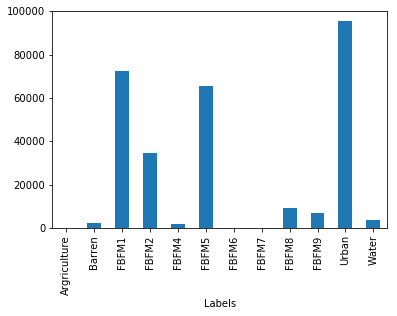

In [87]:
df.groupby(['Labels'])['Year'].count().plot(kind='bar');

# Base Model

The base model uses SGD's default parameters at 5 fold cross validation.

In [88]:
n_samples = len(df)
X = normalize(image_features)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [89]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge',)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [90]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [91]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

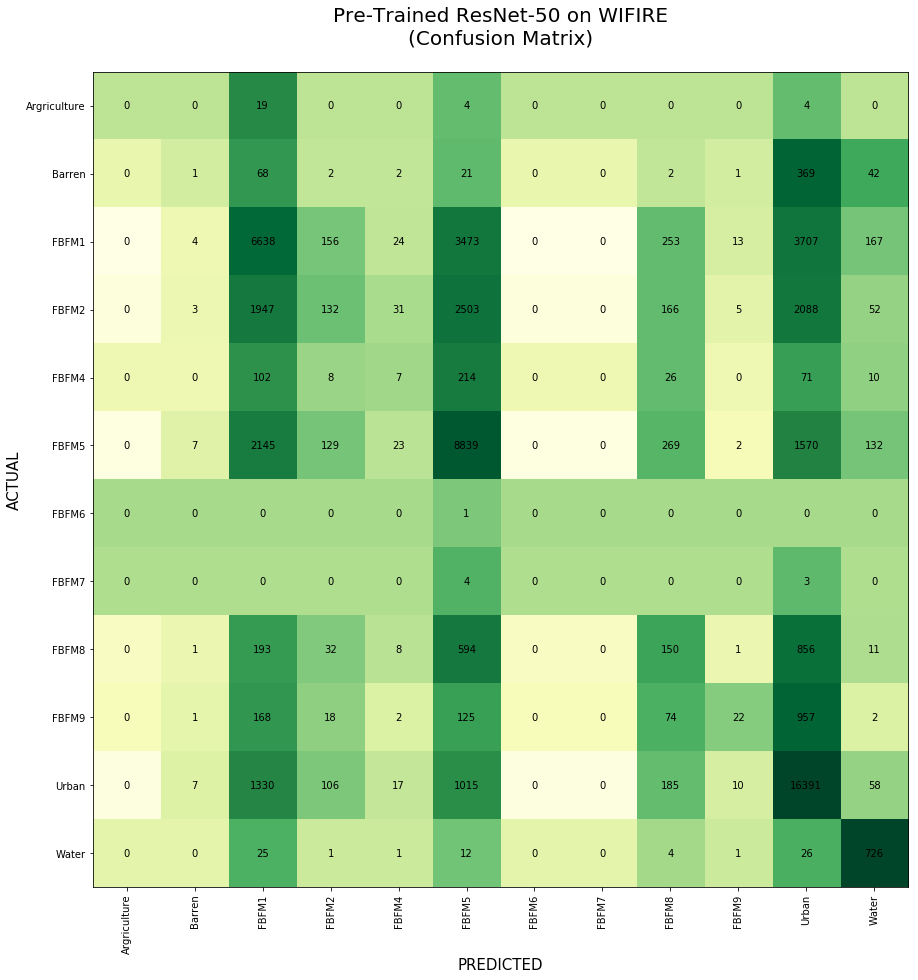

In [92]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

Poor classification achieved. The confusion matrix is very... 

CONFUSING!!! (pun intended.. *badam tiss*)

#### Validation Score

In [93]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

56.164126371844546

# PCA Based Model

#### Original Dimensions

In [94]:
from sklearn.decomposition import PCA

M = normalize(image_features)

pca = PCA(n_components=np.shape(M)[1]) 
T = pca.fit_transform(M) 
T.shape

(292943, 1000)

#### Variance Captured by PCA

[ 0.30293285  0.12561902  0.06859981  0.04985818  0.03701486  0.02205899
  0.01994912  0.01830744  0.01672325  0.01505453]


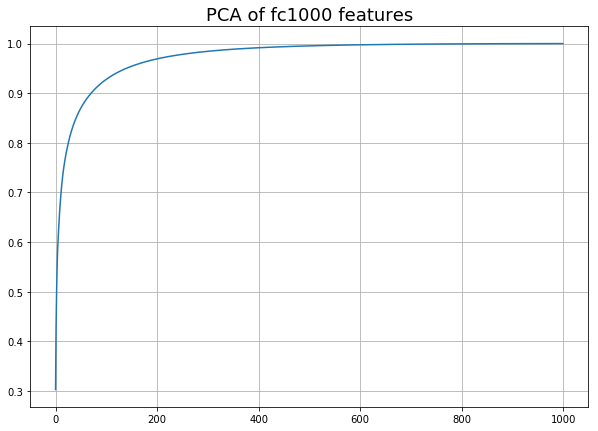

In [95]:
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(10,7))
plt.plot(cumulative_explained);
#xlim([0,365])
plt.grid()
plt.title('PCA of fc1000 features', fontsize=18)

print(pca.explained_variance_ratio_[:10])

In [96]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [97]:
n_samples = len(df)
X = normalize(T)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [98]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ('hinge', 'log'), 'penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [99]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

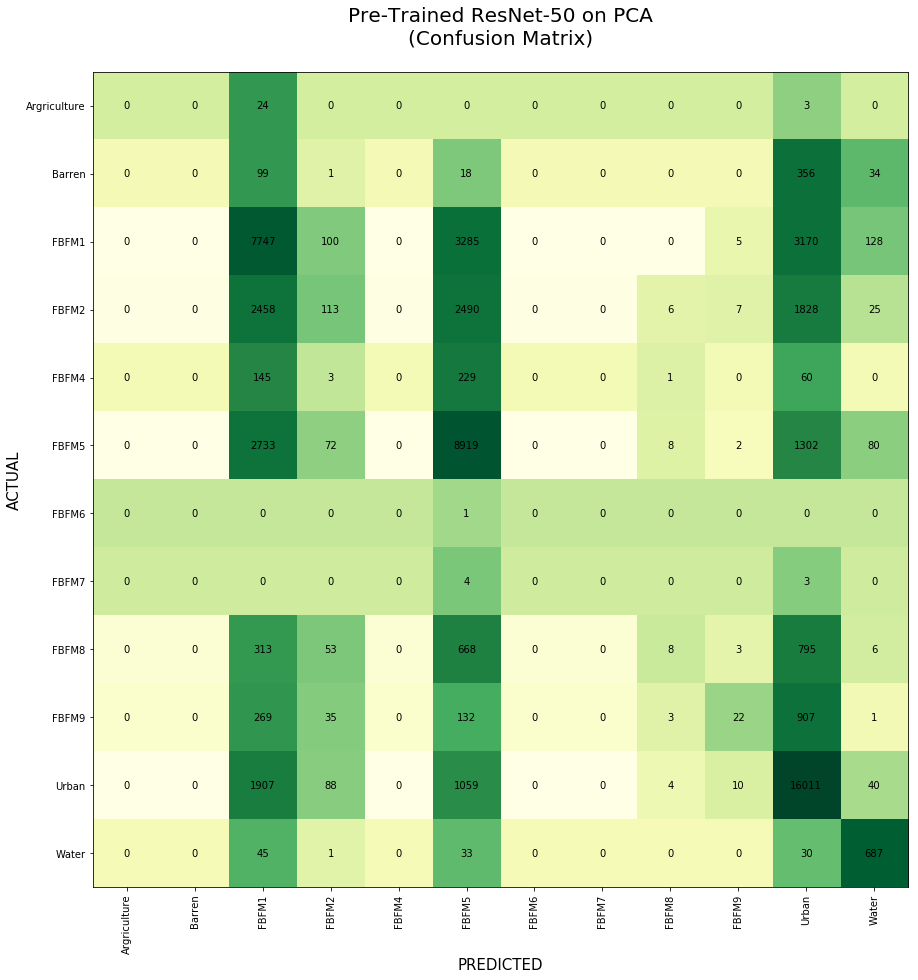

In [100]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA\n(Confusion Matrix)\n', fontsize=20);

#### Validation Score

In [101]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

57.189916195872947

#### Optimal Parameters

In [102]:
classifier.best_params_

{'loss': 'log', 'penalty': 'l2'}

## High Frequency Classes 

In [103]:
high_dist_class_list = ['FBFM1','FBFM5','Urban']

In [108]:
df = df.reset_index()

In [109]:
df_high_class = df[df.Labels.isin(high_dist_class_list)]
high_class_idx = np.array(df_high_class.index)

In [110]:
n_samples = len(df)
X = normalize(image_features[high_class_idx])
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [111]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters = {'loss':('log','hinge'),
             'penalty':('l1','l2','none')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ('log', 'hinge'), 'penalty': ('l1', 'l2', 'none')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [112]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [113]:
np.unique(y_test)

array(['FBFM1', 'FBFM5', 'Urban'], dtype=object)

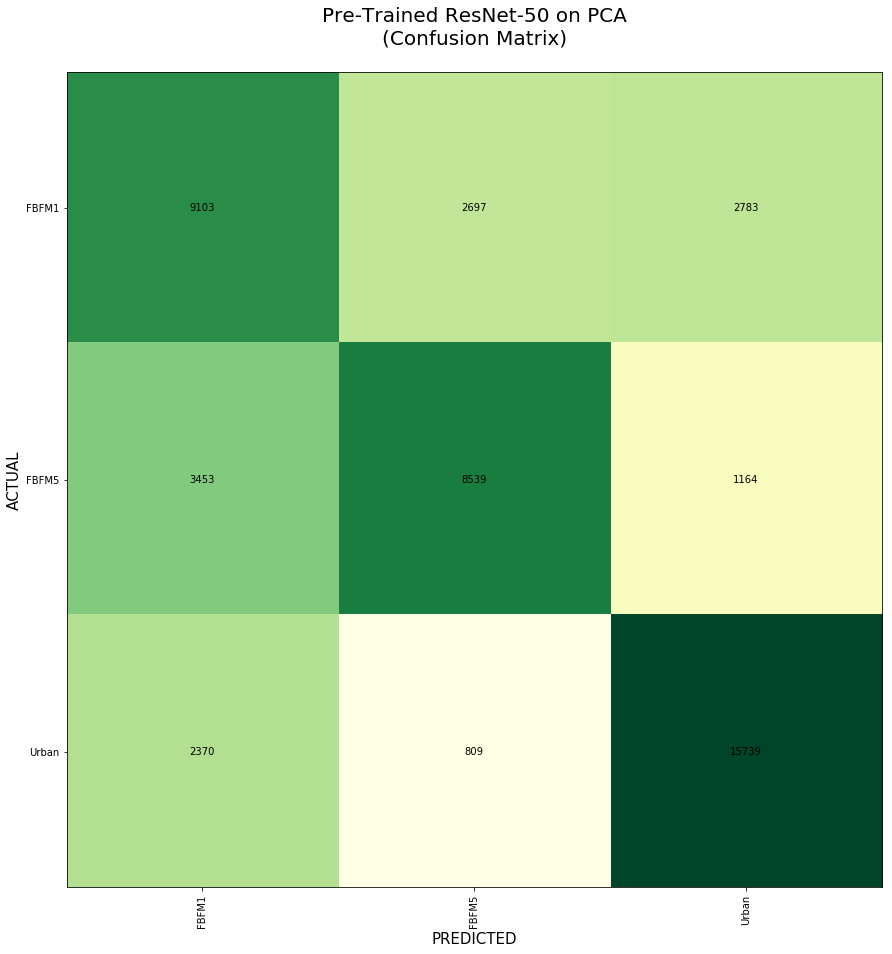

In [114]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA\n(Confusion Matrix)\n', fontsize=20);

#### Validation Score

In [115]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

71.545534432132371

In [116]:
classifier.best_params_

{'loss': 'hinge', 'penalty': 'none'}

## High Frequency with PCA

#### Original Dimensions

In [117]:
from sklearn.decomposition import PCA

M = normalize(image_features[high_class_idx])

pca = PCA(n_components=np.shape(M)[1]) 
T = pca.fit_transform(M) 
T.shape

(233282, 1000)

#### Variance Capture by PCA

[ 0.31852844  0.11970612  0.06508721  0.04791676  0.03677623  0.02229909
  0.01862898  0.01830722  0.01646647  0.01492899]


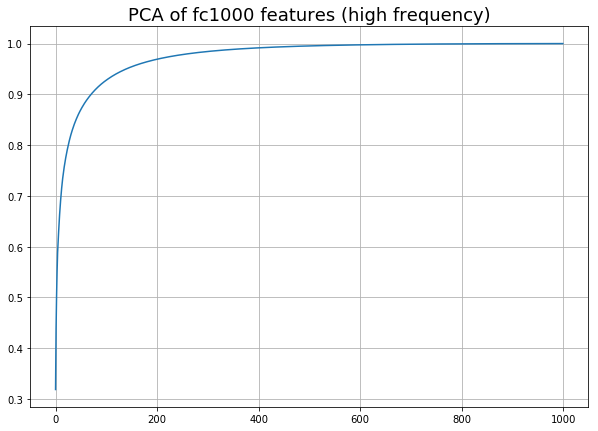

In [118]:
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(10,7))
plt.plot(cumulative_explained);
#xlim([0,365])
plt.grid()
plt.title('PCA of fc1000 features (high frequency)', fontsize=18)

print(pca.explained_variance_ratio_[:10])

In [119]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [120]:
n_samples = len(df)
X = normalize(T)
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [121]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ('hinge', 'log'), 'penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [122]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

#### Validation Score

In [123]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

70.906830700645131

#### Optimal Parameters

In [124]:
classifier.best_params_

{'loss': 'hinge', 'penalty': 'l2'}

## Analyze Iterations at High Frequency and PCA

In [125]:
X = normalize(T)
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [126]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2','none'),
              'n_iter':range(1,10)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5, n_jobs=-1)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_iter': range(1, 10), 'loss': ('hinge', 'log'), 'penalty': ('l1', 'l2', 'none')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [127]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

#### Validation Score

In [128]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

71.635553078852041

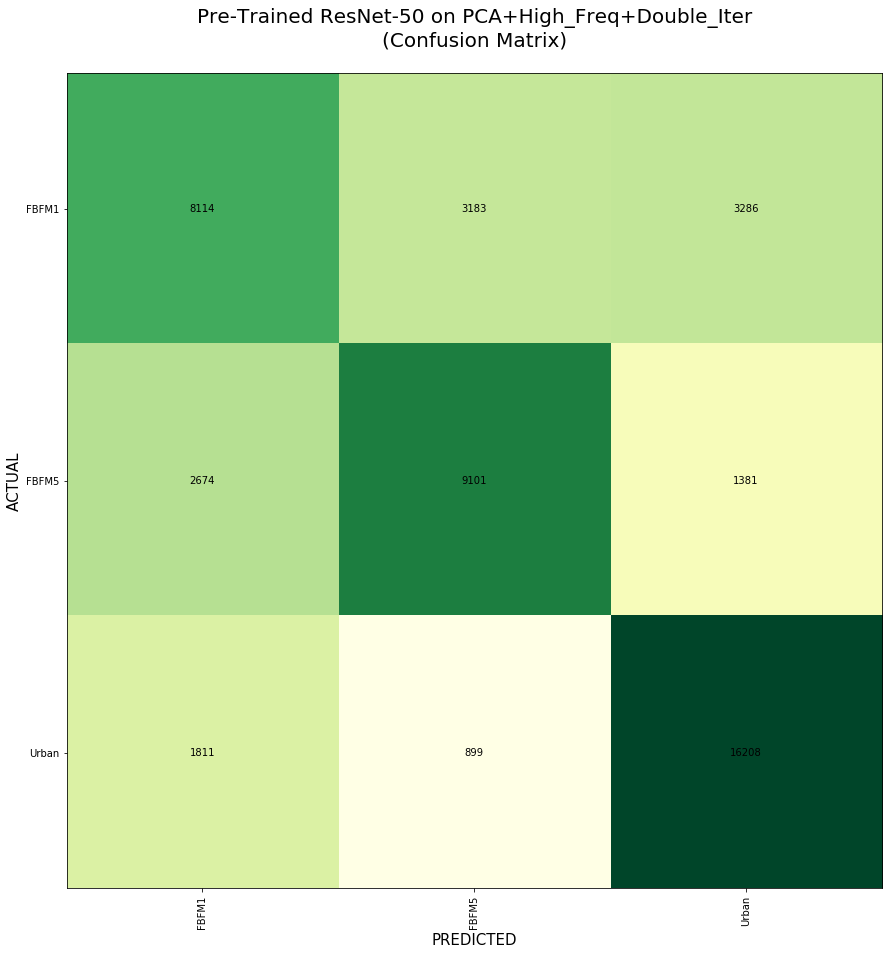

In [129]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA+High_Freq+Double_Iter\n(Confusion Matrix)\n', fontsize=20);

#### Optimal Parameters

In [130]:
classifier.best_params_

{'loss': 'hinge', 'n_iter': 8, 'penalty': 'none'}

## Classification Report (With 2012)

In [133]:
from sklearn.metrics import classification_report

In [134]:
root = "/home/ssnazrul/WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features = pd.read_csv(root+"WIFIRE_fc1000_engineered_features.csv",  delimiter=',', header=None)
df = pd.read_csv(root+'WIFIRE_labels.csv')
labels = df.Labels.values

In [135]:
X = normalize(image_features.values)
y = df.Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge',)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

#Attempt to predict validation data
predict_target = classifier.predict(X_test)

print(classification_report(y_test, predict_target))

              precision    recall  f1-score   support

Argriculture       0.00      0.00      0.00        53
      Barren       0.02      0.00      0.00       775
       FBFM1       0.50      0.43      0.46     21040
       FBFM2       0.20      0.01      0.02     10441
       FBFM4       0.05      0.03      0.03       459
       FBFM5       0.54      0.68      0.60     20476
       FBFM6       0.00      0.00      0.00         5
       FBFM7       0.00      0.00      0.00         8
       FBFM8       0.11      0.01      0.01      2744
       FBFM9       0.20      0.02      0.03      2130
       Urban       0.60      0.88      0.71     28161
       Water       0.60      0.88      0.72      1139

 avg / total       0.48      0.56      0.49     87431



/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
10441/87431*100

11.941988539534032

## Classification Report (Without 2012)

In [138]:
df['Year'] = df.Path.apply(lambda x: x.split('/')[-1].split('_')[3])
idx = df[df.Year != '2012'].index

In [139]:
df.Year.unique()

array(['2010', '2012', '2014'], dtype=object)

In [141]:
X = normalize(image_features.values)[idx]
y = df.Labels.values[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge',)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

#Attempt to predict validation data
predict_target = classifier.predict(X_test)

print(classification_report(y_test, predict_target))

              precision    recall  f1-score   support

Argriculture       0.00      0.00      0.00        27
      Barren       0.04      0.00      0.00       508
       FBFM1       0.53      0.46      0.49     14435
       FBFM2       0.23      0.02      0.04      6927
       FBFM4       0.06      0.02      0.03       438
       FBFM5       0.53      0.67      0.59     13116
       FBFM6       0.00      0.00      0.00         1
       FBFM7       0.00      0.00      0.00         7
       FBFM8       0.13      0.08      0.10      1846
       FBFM9       0.40      0.02      0.03      1369
       Urban       0.63      0.86      0.73     19119
       Water       0.60      0.91      0.73       796

 avg / total       0.50      0.56      0.51     58589



/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
